# Exercise 2 (+ 3) - Group 4
- Matthias Egli
- Florian Bär
- Manuel Vogel
- Adrian Willi

In [86]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torchsummary import summary
import numpy as np
import matplotlib.pyplot as plt

### Loading Data

In [2]:
training_data = datasets.mnist.FashionMNIST(root="data", train=True, download=True, transform=ToTensor())
test_data = datasets.mnist.FashionMNIST(root="data", train=False, download=True, transform=ToTensor())

100.0%


Extracting data\FashionMNIST\raw\train-images-idx3-ubyte.gz to data\FashionMNIST\raw



100.6%
0.0%

Extracting data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to data\FashionMNIST\raw



100.0%


Extracting data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to data\FashionMNIST\raw



119.3%


Extracting data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to data\FashionMNIST\raw



In [3]:
training_data, validation_data = torch.utils.data.random_split(training_data, [50000, 10000])

In [4]:
print(len(training_data),len(validation_data),len(test_data))

50000 10000 10000


### MLP


In [6]:
def mlp(units = [28*28,250,80,10]):
    seq = [torch.nn.Flatten()]
    for i in range(len(units)-2):
        seq.append(torch.nn.Linear(units[i],units[i+1]))
        seq.append(torch.nn.Sigmoid())
    seq.append(torch.nn.Linear(units[-2],units[-1]))
    return torch.nn.Sequential(*seq)

In [7]:
model = mlp()
from torchsummary import summary
summary(model, (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 250]         196,250
           Sigmoid-3                  [-1, 250]               0
            Linear-4                   [-1, 80]          20,080
           Sigmoid-5                   [-1, 80]               0
            Linear-6                   [-1, 10]             810
Total params: 217,140
Trainable params: 217,140
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.83
Estimated Total Size (MB): 0.84
----------------------------------------------------------------


### Training

Implement the training / evaluation loop

Remember training / validation cost and accuracy per epoch. 

In [8]:
def train_eval(model, optimizer, nepochs, training_loader, test_loader, scheduler=None):
    cost_hist = []
    cost_hist_test = []
    acc_hist = []
    acc_hist_test = []

    cost_ce = torch.nn.CrossEntropyLoss()
        
    for epoch in range(nepochs):
        model.train()
        size = len(training_loader.dataset)
        nbatches = len(training_loader)
        size_test = len(test_loader.dataset)
        nbatches_test = len(test_loader)
        cost, acc = 0.0, 0.0
        for batch, (X, Y) in enumerate(training_loader):
            pred = model(X)
            loss = cost_ce(pred, Y)
            cost += loss.item()
            acc += (pred.argmax(dim=1) == Y).type(torch.float).sum().item()

            # gradient, parameter update
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if scheduler:
            scheduler.step()
        cost /= nbatches
        acc /= size
    
        model.eval()
        cost_test, acc_test = 0.0, 0.0        
        with torch.no_grad():
            for X, Y in test_loader:
                pred = model(X)
                cost_test += cost_ce(pred, Y).item()
                acc_test += (pred.argmax(dim=1) == Y).type(torch.float).sum().item()
        cost_test /= nbatches_test
        acc_test /= size_test
        print("Epoch %i: %f, %f, %f, %f"%(epoch, cost, acc, cost_test, acc_test))
        cost_hist.append(cost)
        cost_hist_test.append(cost_test)
        acc_hist.append(acc)
        acc_hist_test.append(acc_test)
    return cost_hist, cost_hist_test, acc_hist, acc_hist_test

### Analyse Different Optimisers with different Settings 

Use the code above to explore different settings for the different optimizers. Use batchsize 64.

1. SGD: Revisit plain SGD (without momentum) and try different learning rates (lr). Create suitable comparison plots (learning curves with the train and validate cost and accuracy) for (~3) different learning rates. Describe in words what you see. What is a reasonable number of epochs (nepochs)? What is your recommended best choice (lr, nepochs) for the given problem?

2. Momentum: Play with different settings when using momentum: learning rate, momentum parameter, Nesterov flag. Start with momentum=0.9 without Nesterov and suitable learning rate, then vary the momentum parameter and independently the learning rate. Can you see an impact of using Nesterov? What is your recommended best choice (lr, momentum, nesterov, nepochs) for the given problem?

3. RMSprop: Same thing now for RMSprop (without momentum). Play with different settings when using RMSprop: lr, alpha. Start with the default settings of pytorch with (lr=0.01, alpha=0.99,centered=False). Then vary alpha and independently the learning rate. Can you see an impact when using centered=True? What is your recommended best choice (learning rate, alpha, centered, nepochs) for the given problem?

4. Adam: Same thing now for Adam. Play with different settings. Start with the default settings of pytorch. What is your recommended best choice for the given problem?

5. Learning rate schedule: Implement a learning rate schedule for SGD (without momentum) - by using e.g. StepLR. What are your preferred settings for the given task? Note the way how the scheduler is incorporated into the `train_eval`-method above.


## 1. SGD
Revisit plain SGD (without momentum) and try different learning rates (lr). Create suitable comparison plots (learning curves with the train and validate cost and accuracy) for (~3) different learning rates. Describe in words what you see. What is a reasonable number of epochs (nepochs)? What is your recommended best choice (lr, nepochs) for the given problem?

In [55]:
nbatch = 64
nepochs = [10, 10, 10, 30, 30, 30]
lr = [0.1, 0.4, 0.8, 0.1, 0.4, 0.8]
    
costs_train = []
costs_test = []
acc_train = []
acc_test = []

for i in range(len(lr)):
    print("-"*10 + "Learning rate: " + str(lr[i]) + ", Epochs: " + str(nepochs[i]) + "-"*10)
    training_loader = DataLoader(training_data, batch_size=nbatch, shuffle=True)
    validation_loader = DataLoader(validation_data, batch_size=nbatch, shuffle=True)
    model = mlp()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr[i])
    cost_hist, cost_hist_test, acc_hist, acc_hist_test = train_eval(model, optimizer, nepochs[i], training_loader, validation_loader)
    
    costs_train.append(cost_hist)
    costs_test.append(cost_hist_test)
    acc_train.append(acc_hist)
    acc_test.append(acc_hist_test)

----------Learning rate: 0.1, Epochs: 10----------
Epoch 0: 1.723245, 0.389620, 1.056099, 0.604800
Epoch 1: 0.880868, 0.667480, 0.747450, 0.706100
Epoch 2: 0.677919, 0.746620, 0.657889, 0.751500
Epoch 3: 0.597162, 0.777480, 0.592399, 0.764800
Epoch 4: 0.551191, 0.803700, 0.519900, 0.810700
Epoch 5: 0.518714, 0.816040, 0.513011, 0.812200
Epoch 6: 0.494716, 0.825220, 0.573795, 0.782900
Epoch 7: 0.476393, 0.830780, 0.461324, 0.833400
Epoch 8: 0.460730, 0.834860, 0.461311, 0.831400
Epoch 9: 0.448410, 0.841060, 0.510129, 0.812000
----------Learning rate: 0.4, Epochs: 10----------
Epoch 0: 1.054750, 0.593020, 0.868267, 0.663400
Epoch 1: 0.569396, 0.788640, 0.540666, 0.806200
Epoch 2: 0.493487, 0.820700, 0.527670, 0.802500
Epoch 3: 0.453109, 0.835700, 0.445167, 0.833700
Epoch 4: 0.423849, 0.847820, 0.480216, 0.831600
Epoch 5: 0.399659, 0.853840, 0.552474, 0.795100
Epoch 6: 0.383908, 0.858640, 0.497060, 0.824300
Epoch 7: 0.369189, 0.864600, 0.364081, 0.869000
Epoch 8: 0.358993, 0.868140, 0.402

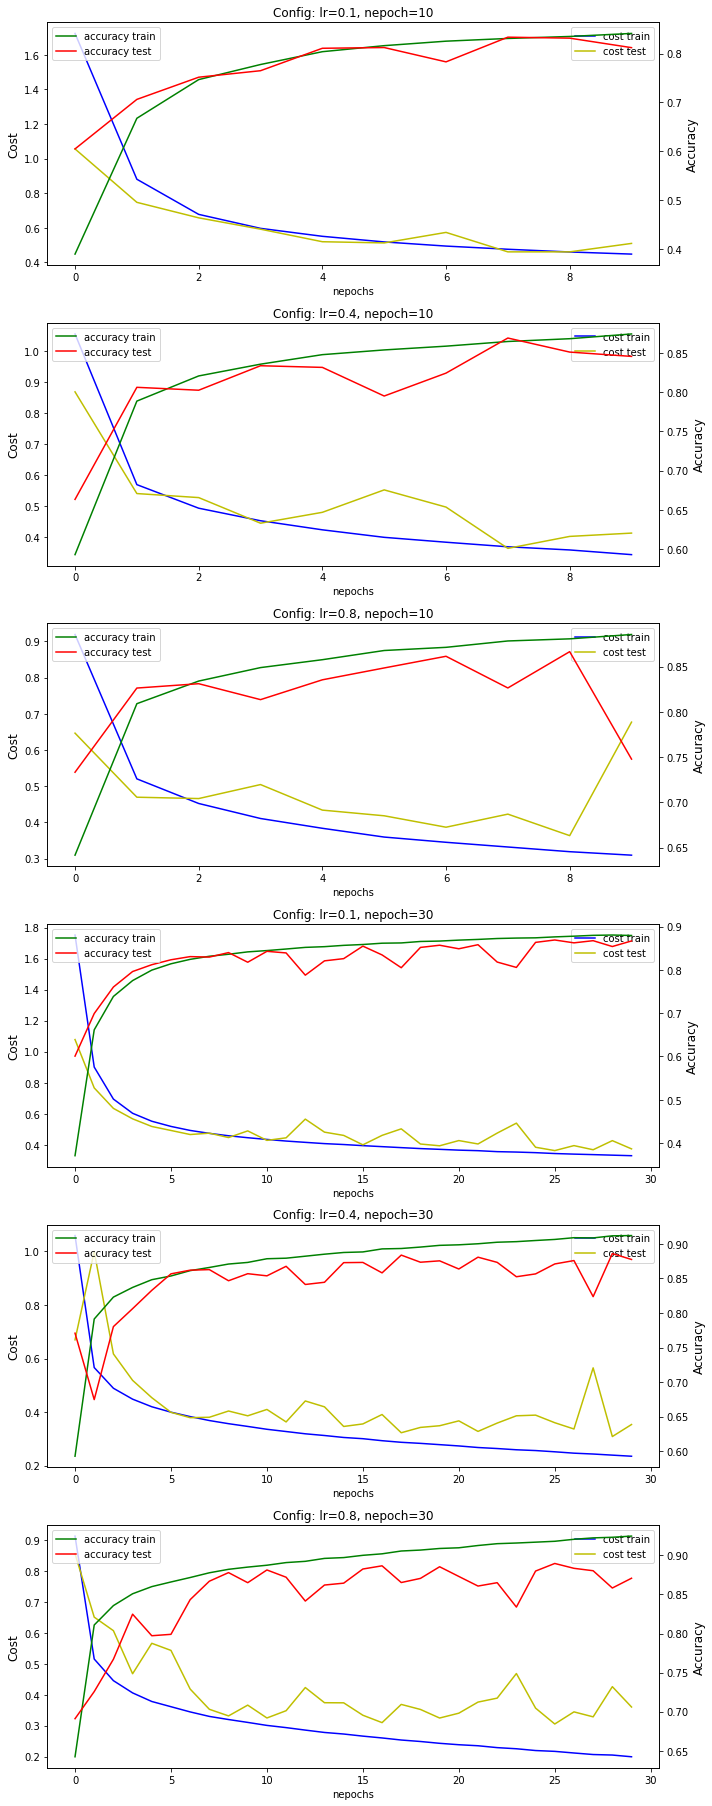

In [56]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,25)

for i in range(len(lr)):
    plt.subplot(6, 1, 1+i)
    plt.tight_layout()
    plt.plot(torch.arange(nepochs[i]), costs_train[i], label="cost train", color="b")
    plt.plot(torch.arange(nepochs[i]), costs_test[i], label="cost test", color="y")
    plt.legend()
    plt.xlabel("nepochs")
    plt.ylabel("Cost", fontsize=12)
    plt.title(f"Config: lr={lr[i]}, nepoch={nepochs[i]}")
    plt2 = plt.twinx()
    plt2.plot(torch.arange(nepochs[i]), acc_train[i], label="accuracy train", color="g")
    plt2.plot(torch.arange(nepochs[i]), acc_test[i], label="accuracy test", color="r")
    plt2.legend()
    plt2.set_ylabel("Accuracy", fontsize=12)

## 2.Momentum: 
Play with different settings when using momentum: learning rate, momentum parameter, Nesterov flag. Start with momentum=0.9 without Nesterov and suitable learning rate, then vary the momentum parameter and independently the learning rate. Can you see an impact of using Nesterov? What is your recommended best choice (lr, momentum, nesterov, nepochs) for the given problem?

In [58]:
nbatch = 64
nepochs = [10, 10, 10, 10, 10, 10, 20, 20, 20, 20, 20, 20]
lr = [0.1, 0.4, 0.8, 0.1, 0.4, 0.8, 0.1, 0.4, 0.8, 0.1, 0.4, 0.8]
momentum = [0.9, 0.5, 0.1, 0.9, 0.5, 0.1, 0.9, 0.5, 0.1, 0.9, 0.5, 0.1]
nesterov = [False, False, False, True, True, True, False, False, False, True, True, True]
    
costs_train_mom = []
costs_test_mom = []
acc_train_mom = []
acc_test_mom = []

for i in range(len(lr)):
    print("-"*10 + "Learning rate: " + str(lr[i]) + ", Momentum: " + str(momentum[i]) + ", Nesterov: " + str(nesterov[i]) + ", Epochs: " + str(nepochs[i]) + "-"*10)
    training_loader = DataLoader(training_data, batch_size=nbatch, shuffle=True)
    validation_loader = DataLoader(validation_data, batch_size=nbatch, shuffle=True)
    model = mlp()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr[i], momentum=momentum[i], nesterov=nesterov[i])
    cost_hist, cost_hist_test, acc_hist, acc_hist_test = train_eval(model, optimizer, nepochs[i], training_loader, validation_loader)
    
    costs_train_mom.append(cost_hist)
    costs_test_mom.append(cost_hist_test)
    acc_train_mom.append(acc_hist)
    acc_test_mom.append(acc_hist_test)

----------Learning rate: 0.1, Momentum: 0.9, Nesterov: False, Epochs: 10----------
Epoch 0: 0.837281, 0.680540, 0.506021, 0.815300
Epoch 1: 0.473785, 0.829400, 0.434994, 0.840300
Epoch 2: 0.415955, 0.850560, 0.392110, 0.856100
Epoch 3: 0.383118, 0.859500, 0.380895, 0.860100
Epoch 4: 0.357925, 0.868880, 0.363133, 0.869900
Epoch 5: 0.340950, 0.875240, 0.375353, 0.863300
Epoch 6: 0.325896, 0.878900, 0.346700, 0.870400
Epoch 7: 0.314522, 0.883180, 0.392141, 0.864200
Epoch 8: 0.302005, 0.887720, 0.335046, 0.874800
Epoch 9: 0.293366, 0.890440, 0.360376, 0.863200
----------Learning rate: 0.4, Momentum: 0.5, Nesterov: False, Epochs: 10----------
Epoch 0: 0.864512, 0.669680, 0.564717, 0.790200
Epoch 1: 0.492617, 0.820500, 0.483490, 0.822700
Epoch 2: 0.431037, 0.843720, 0.440858, 0.838400
Epoch 3: 0.396225, 0.855580, 0.430903, 0.834900
Epoch 4: 0.369191, 0.864540, 0.566403, 0.794100
Epoch 5: 0.352281, 0.870400, 0.365734, 0.865300
Epoch 6: 0.335647, 0.876540, 0.523780, 0.803900
Epoch 7: 0.322795,

Epoch 11: 0.287821, 0.891620, 0.358741, 0.872700
Epoch 12: 0.278556, 0.895000, 0.346446, 0.874300
Epoch 13: 0.272329, 0.898960, 0.392091, 0.849200
Epoch 14: 0.265936, 0.900260, 0.350400, 0.875800
Epoch 15: 0.259761, 0.902440, 0.373616, 0.866300
Epoch 16: 0.253410, 0.904200, 0.302016, 0.890100
Epoch 17: 0.247073, 0.907640, 0.333262, 0.875800
Epoch 18: 0.241673, 0.909120, 0.345470, 0.881500
Epoch 19: 0.237074, 0.911000, 0.376751, 0.864400
----------Learning rate: 0.8, Momentum: 0.1, Nesterov: True, Epochs: 20----------
Epoch 0: 0.905498, 0.647660, 0.580620, 0.782000
Epoch 1: 0.511244, 0.811540, 0.772298, 0.761900
Epoch 2: 0.439825, 0.838540, 0.440828, 0.843100
Epoch 3: 0.402583, 0.852840, 0.595680, 0.795900
Epoch 4: 0.376832, 0.860480, 0.447539, 0.843300
Epoch 5: 0.356286, 0.867960, 0.521561, 0.809200
Epoch 6: 0.336091, 0.874020, 0.371763, 0.860300
Epoch 7: 0.324732, 0.880300, 0.455160, 0.832800
Epoch 8: 0.316009, 0.882840, 0.468533, 0.825500
Epoch 9: 0.304951, 0.886580, 0.336399, 0.8715

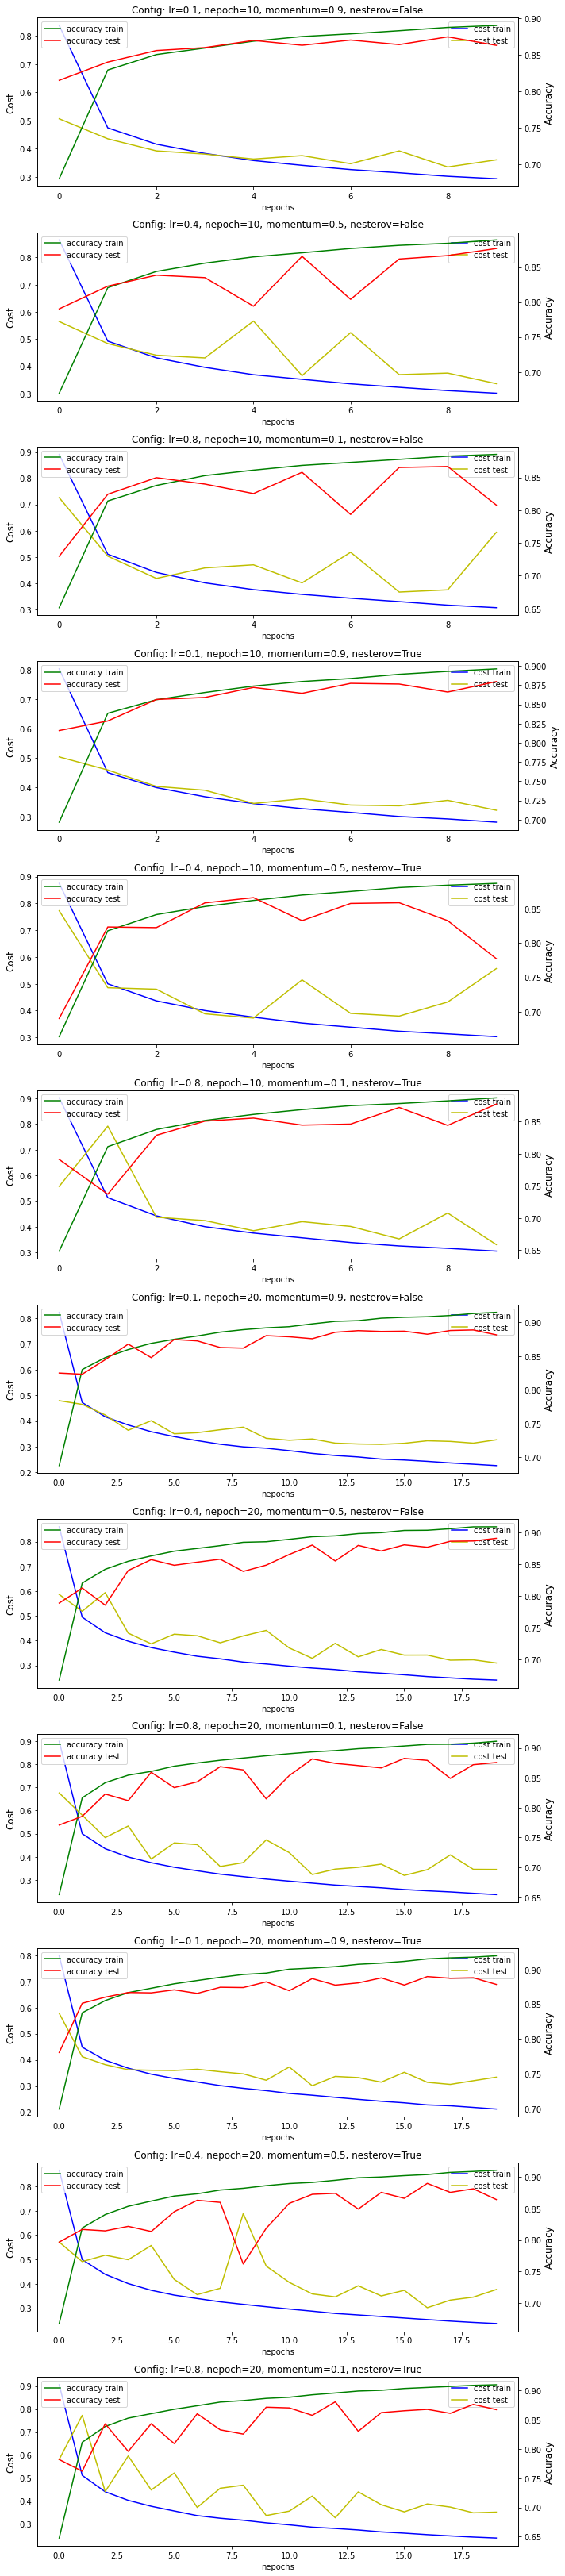

In [67]:
plt.rcParams["figure.figsize"] = (10,45)

for i in range(len(lr)):
    plt.subplot(12,1,1+i)
    plt.tight_layout()
    plt.plot(torch.arange(nepochs[i]), costs_train_mom[i], label="cost train", color="b")
    plt.plot(torch.arange(nepochs[i]), costs_test_mom[i], label="cost test", color="y")
    plt.legend()
    plt.xlabel("nepochs")
    plt.ylabel("Cost", fontsize=12)
    plt.title(f"Config: lr={lr[i]}, nepoch={nepochs[i]}, momentum={momentum[i]}, nesterov={nesterov[i]}")
    plt2 = plt.twinx()
    plt2.plot(torch.arange(nepochs[i]), acc_train_mom[i], label="accuracy train", color="g")
    plt2.plot(torch.arange(nepochs[i]), acc_test_mom[i], label="accuracy test", color="r")
    plt2.legend()
    plt2.set_ylabel("Accuracy", fontsize=12)

### Finding best parameters (lr, momentum, nesterov, nepochs)

## 3. RMSprop: 
Same thing now for RMSprop (without momentum). Play with different settings when using RMSprop: lr, alpha. Start with the default settings of pytorch with (lr=0.01, alpha=0.99,centered=False). Then vary alpha and independently the learning rate. Can you see an impact when using centered=True? What is your recommended best choice (learning rate, alpha, centered, nepochs) for the given problem?
- - -


In [69]:
nbatch = 64
nepochs =  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,]
lr =       [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001]
alpha =    [0.99, 0.99, 0.5, 0.5, 0.1, 0.1, 0.99, 0.99, 0.5, 0.5, 0.1, 0.1]
centered = [False, True, False, True, False, True, False, True, False, True, False, True]
    
costs_train_rms = []
costs_test_rms = []
acc_train_rms = []
acc_test_rms = []

for i in range(len(lr)):
    print("-"*10 + "Learning rate: " + str(lr[i]) + ", Alpha: " + str(alpha[i]) + ", Centered: " + str(centered[i]) + ", Epochs: " + str(nepochs[i]) + "-"*10)
    training_loader = DataLoader(training_data, batch_size=nbatch, shuffle=True)
    validation_loader = DataLoader(validation_data, batch_size=nbatch, shuffle=True)
    model = mlp()
    optimizer = torch.optim.RMSprop(model.parameters(), lr=lr[i], alpha=alpha[i], centered=centered[i])
    cost_hist, cost_hist_test, acc_hist, acc_hist_test = train_eval(model, optimizer, nepochs[i], training_loader, validation_loader)
    
    costs_train_rms.append(cost_hist)
    costs_test_rms.append(cost_hist_test)
    acc_train_rms.append(acc_hist)
    acc_test_rms.append(acc_hist_test)

----------Learning rate: 0.01, Alpha: 0.99, Centered: False, Epochs: 10----------
Epoch 0: 0.958000, 0.622320, 0.659657, 0.754900
Epoch 1: 0.497739, 0.820560, 0.534342, 0.802400
Epoch 2: 0.445619, 0.838940, 0.455342, 0.837600
Epoch 3: 0.425444, 0.846500, 0.468296, 0.833900
Epoch 4: 0.407844, 0.852160, 0.496657, 0.832000
Epoch 5: 0.395895, 0.856720, 0.738337, 0.753800
Epoch 6: 0.392196, 0.858700, 0.689490, 0.730800
Epoch 7: 0.389740, 0.859660, 0.425115, 0.846800
Epoch 8: 0.378533, 0.863160, 0.409399, 0.854100
Epoch 9: 0.376294, 0.863420, 0.530555, 0.805200
----------Learning rate: 0.01, Alpha: 0.99, Centered: True, Epochs: 10----------
Epoch 0: 0.852254, 0.676140, 0.573197, 0.755100
Epoch 1: 0.479695, 0.825860, 0.464570, 0.834400
Epoch 2: 0.439456, 0.839780, 0.518076, 0.811100
Epoch 3: 0.418121, 0.847640, 0.527676, 0.801800
Epoch 4: 0.405182, 0.853360, 0.426263, 0.846300
Epoch 5: 0.393295, 0.857380, 0.483729, 0.838500
Epoch 6: 0.394738, 0.855360, 0.439574, 0.851600
Epoch 7: 0.385856, 0.

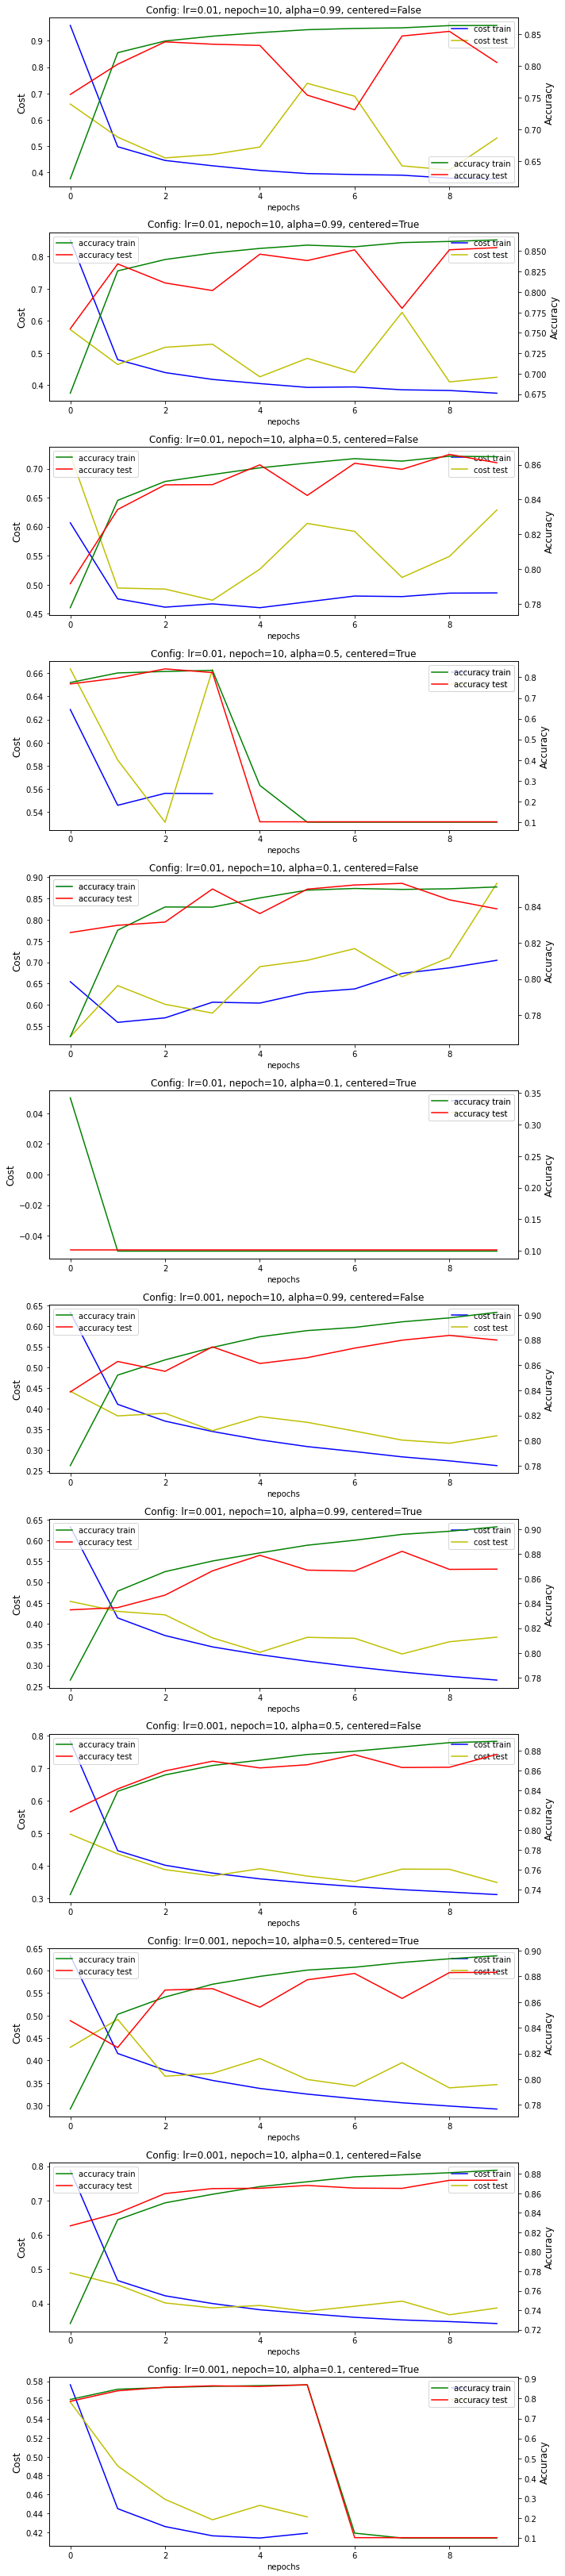

In [70]:
plt.rcParams["figure.figsize"] = (10,45)

for i in range(len(lr)):
    plt.subplot(12,1,1+i)
    plt.tight_layout()
    plt.plot(torch.arange(nepochs[i]), costs_train_rms[i], label="cost train", color="b")
    plt.plot(torch.arange(nepochs[i]), costs_test_rms[i], label="cost test", color="y")
    plt.legend()
    plt.xlabel("nepochs")
    plt.ylabel("Cost", fontsize=12)
    plt.title(f"Config: lr={lr[i]}, nepoch={nepochs[i]}, alpha={alpha[i]}, centered={centered[i]}")
    plt2 = plt.twinx()
    plt2.plot(torch.arange(nepochs[i]), acc_train_rms[i], label="accuracy train", color="g")
    plt2.plot(torch.arange(nepochs[i]), acc_test_rms[i], label="accuracy test", color="r")
    plt2.legend()
    plt2.set_ylabel("Accuracy", fontsize=12)

## 4. Adam: 
Same thing now for Adam. Play with different settings. Start with the default settings of pytorch. What is your recommended best choice for the given problem?
- - -


In [71]:
nbatch = 64
nepochs = [10, 10, 10, 10, 10, 10, 20, 20, 20, 20, 20, 20]
lr = [0.001, 0.01, 0.1, 0.001, 0.01, 0.1, 0.001, 0.01, 0.1, 0.001, 0.01, 0.1]
betas = [(0.9, 0.999), (0.9, 0.999), (0.9, 0.999), (0.8, 0.9), (0.8, 0.9), (0.8, 0.9), (0.9, 0.999), (0.9, 0.999), (0.9, 0.999), (0.8, 0.9), (0.8, 0.9), (0.8, 0.9)]
    
costs_train_adam = []
costs_test_adam = []
acc_train_adam = []
acc_test_adam = []

for i in range(len(lr)):
    print("-"*10 + "Learning rate: " + str(lr[i]) + ", Betas: " + str(betas[i]) + ", Epochs: " + str(nepochs[i]) + "-"*10)
    training_loader = DataLoader(training_data, batch_size=nbatch, shuffle=True)
    validation_loader = DataLoader(validation_data, batch_size=nbatch, shuffle=True)
    model = mlp()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr[i], betas=betas[i])
    cost_hist, cost_hist_test, acc_hist, acc_hist_test = train_eval(model, optimizer, nepochs[i], training_loader, validation_loader)
    
    costs_train_adam.append(cost_hist)
    costs_test_adam.append(cost_hist_test)
    acc_train_adam.append(acc_hist)
    acc_test_adam.append(acc_hist_test)   

----------Learning rate: 0.001, Betas: (0.9, 0.999), Epochs: 10----------
Epoch 0: 0.786179, 0.733700, 0.453703, 0.841000
Epoch 1: 0.422689, 0.848940, 0.381042, 0.865000
Epoch 2: 0.372607, 0.866340, 0.365854, 0.866300
Epoch 3: 0.342797, 0.876000, 0.346973, 0.872700
Epoch 4: 0.322460, 0.883380, 0.346654, 0.872900
Epoch 5: 0.307899, 0.887340, 0.331671, 0.881000
Epoch 6: 0.294906, 0.892040, 0.321562, 0.883700
Epoch 7: 0.281782, 0.895640, 0.315508, 0.885700
Epoch 8: 0.270444, 0.901040, 0.319823, 0.882600
Epoch 9: 0.262108, 0.903820, 0.308409, 0.887700
----------Learning rate: 0.01, Betas: (0.9, 0.999), Epochs: 10----------
Epoch 0: 0.579679, 0.786560, 0.463759, 0.828700
Epoch 1: 0.442047, 0.840000, 0.417731, 0.848800
Epoch 2: 0.414169, 0.849460, 0.393422, 0.859200
Epoch 3: 0.403628, 0.854640, 0.421487, 0.843100
Epoch 4: 0.394693, 0.857340, 0.397391, 0.861200
Epoch 5: 0.388781, 0.858680, 0.402264, 0.855000
Epoch 6: 0.376635, 0.864420, 0.421531, 0.851700
Epoch 7: 0.380177, 0.864020, 0.403081

Epoch 14: 0.367184, 0.877120, 0.432650, 0.865900
Epoch 15: 0.369384, 0.876220, 0.458895, 0.864300
Epoch 16: 0.366791, 0.876880, 0.435994, 0.866200
Epoch 17: 0.372781, 0.874740, 0.451583, 0.861200
Epoch 18: 0.376657, 0.874840, 0.454045, 0.867100
Epoch 19: 0.375281, 0.874480, 0.473479, 0.870500
----------Learning rate: 0.1, Betas: (0.8, 0.9), Epochs: 20----------
Epoch 0: 1.983293, 0.203300, 2.426293, 0.233200
Epoch 1: 1.980043, 0.208160, 1.899475, 0.215200
Epoch 2: 1.961134, 0.211060, 2.046098, 0.176500
Epoch 3: 1.967491, 0.206600, 2.265472, 0.184000
Epoch 4: 2.022403, 0.198900, 1.907932, 0.192300
Epoch 5: 1.990423, 0.196320, 1.785799, 0.196400
Epoch 6: 1.991103, 0.198840, 2.161832, 0.195900
Epoch 7: 2.038873, 0.194720, 2.130675, 0.194800
Epoch 8: 2.058301, 0.194320, 2.334967, 0.192700
Epoch 9: 1.973353, 0.201260, 1.980580, 0.212200
Epoch 10: 1.987132, 0.196100, 1.989939, 0.195900
Epoch 11: 1.966045, 0.197660, 2.025574, 0.199300
Epoch 12: 1.979942, 0.196480, 2.231381, 0.196800
Epoch 13:

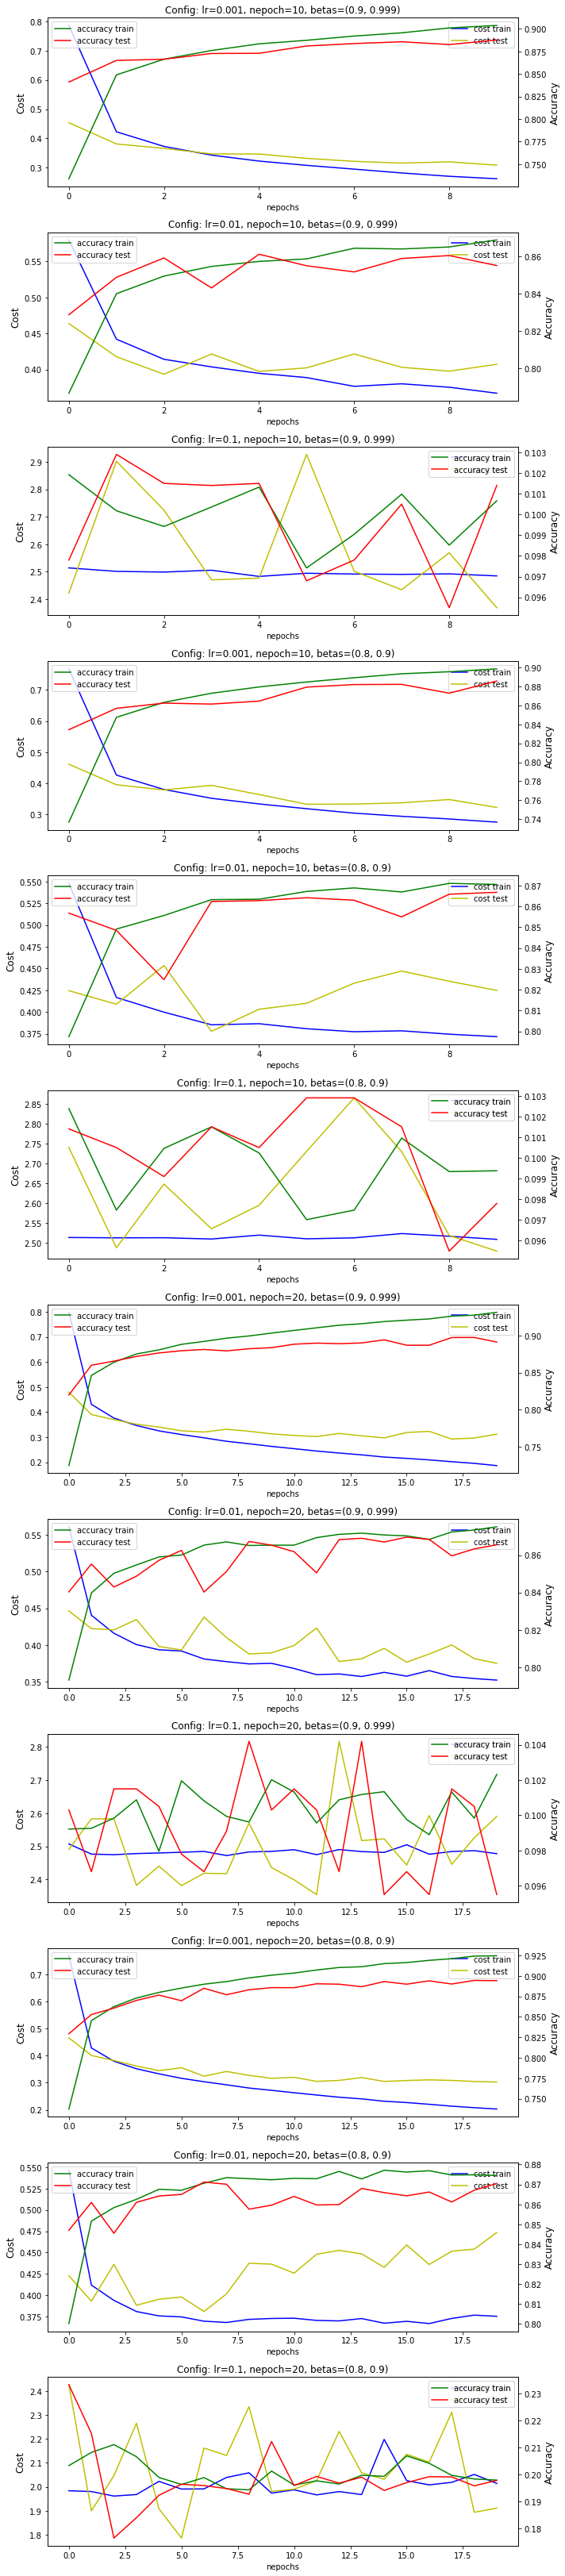

In [74]:
plt.rcParams["figure.figsize"] = (10,45)

for i in range(len(lr)):
    plt.subplot(12,1,1+i)
    plt.tight_layout()
    plt.plot(torch.arange(nepochs[i]), costs_train_adam[i], label="cost train", color="b")
    plt.plot(torch.arange(nepochs[i]), costs_test_adam[i], label="cost test", color="y")
    plt.legend()
    plt.xlabel("nepochs")
    plt.ylabel("Cost", fontsize=12)
    plt.title(f"Config: lr={lr[i]}, nepoch={nepochs[i]}, betas={betas[i]}")
    plt2 = plt.twinx()
    plt2.plot(torch.arange(nepochs[i]), acc_train_adam[i], label="accuracy train", color="g")
    plt2.plot(torch.arange(nepochs[i]), acc_test_adam[i], label="accuracy test", color="r")
    plt2.legend()
    plt2.set_ylabel("Accuracy", fontsize=12)

## 5. Learning rate schedule: 
Implement a learning rate schedule for SGD (without momentum) - by using e.g. StepLR. What are your preferred settings for the given task? Note the way how the scheduler is incorporated into the train_eval-method above.

In [75]:
nbatch = 64
nepochs = [20, 20, 20, 20, 20, 20, 20, 20, 20]
lr = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
step_size = [50, 30, 10, 50, 30, 10, 50, 30, 10]
gamma = [0.1, 0.1, 0.1, 0.4, 0.4, 0.4, 0.01, 0.01, 0.01]  
    
costs_train_steplr = []
costs_test_steplr = []
acc_train_steplr = []
acc_test_steplr = []

for i in range(len(lr)):
    print("-"*10 + "Learning rate: " + str(lr[i]) + ", Step size: " + str(step_size[i]) + ", Gamma: " + str(gamma[i]) + ", Epochs: " + str(nepochs[i]) + "-"*10)
    training_loader = DataLoader(training_data, batch_size=nbatch, shuffle=True)
    validation_loader = DataLoader(validation_data, batch_size=nbatch, shuffle=True)
    model = mlp()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr[i])
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size[i], gamma[i])
    cost_hist, cost_hist_test, acc_hist, acc_hist_test = train_eval(model, optimizer, nepochs[i], training_loader, validation_loader, scheduler)
    
    costs_train_steplr.append(cost_hist)
    costs_test_steplr.append(cost_hist_test)
    acc_train_steplr.append(acc_hist)
    acc_test_steplr.append(acc_hist_test)   

----------Learning rate: 0.1, Step size: 50, Gamma: 0.1, Epochs: 20----------
Epoch 0: 1.767468, 0.361400, 1.109915, 0.628300
Epoch 1: 0.919431, 0.661640, 0.755419, 0.727000
Epoch 2: 0.691685, 0.745220, 0.633022, 0.760500
Epoch 3: 0.603832, 0.774300, 0.590818, 0.782300
Epoch 4: 0.556146, 0.798800, 0.539608, 0.804400
Epoch 5: 0.521570, 0.813040, 0.504214, 0.817000
Epoch 6: 0.496728, 0.824940, 0.469186, 0.832600
Epoch 7: 0.474353, 0.832460, 0.469393, 0.829300
Epoch 8: 0.457967, 0.836860, 0.460914, 0.835800
Epoch 9: 0.443702, 0.842840, 0.450232, 0.837500
Epoch 10: 0.431765, 0.846620, 0.427916, 0.846700
Epoch 11: 0.422794, 0.850580, 0.510419, 0.801900
Epoch 12: 0.414124, 0.852140, 0.422520, 0.848800
Epoch 13: 0.406201, 0.856320, 0.405496, 0.853900
Epoch 14: 0.398499, 0.857800, 0.399237, 0.855100
Epoch 15: 0.392328, 0.860140, 0.400588, 0.855200
Epoch 16: 0.385546, 0.861600, 0.393728, 0.861000
Epoch 17: 0.380933, 0.863080, 0.387523, 0.861300
Epoch 18: 0.374521, 0.864880, 0.428104, 0.843700
E

Epoch 17: 0.383463, 0.863580, 0.445624, 0.842100
Epoch 18: 0.377344, 0.864460, 0.402227, 0.858700
Epoch 19: 0.371834, 0.866540, 0.449775, 0.841400
----------Learning rate: 0.1, Step size: 10, Gamma: 0.01, Epochs: 20----------
Epoch 0: 1.750716, 0.365140, 1.090226, 0.610200
Epoch 1: 0.916272, 0.657960, 0.770695, 0.693100
Epoch 2: 0.693943, 0.740660, 0.648386, 0.761000
Epoch 3: 0.601253, 0.775420, 0.556091, 0.795300
Epoch 4: 0.553184, 0.801520, 0.519484, 0.816700
Epoch 5: 0.520618, 0.814620, 0.523502, 0.808500
Epoch 6: 0.497447, 0.823780, 0.482885, 0.824400
Epoch 7: 0.478441, 0.829520, 0.456404, 0.835700
Epoch 8: 0.461391, 0.836080, 0.461660, 0.836300
Epoch 9: 0.447823, 0.840740, 0.442333, 0.842000
Epoch 10: 0.429840, 0.848160, 0.427097, 0.844100
Epoch 11: 0.428026, 0.849240, 0.426767, 0.844800
Epoch 12: 0.427556, 0.849220, 0.427167, 0.844800
Epoch 13: 0.427030, 0.849000, 0.427364, 0.845100
Epoch 14: 0.427128, 0.849600, 0.426666, 0.844700
Epoch 15: 0.426975, 0.849280, 0.426781, 0.845200


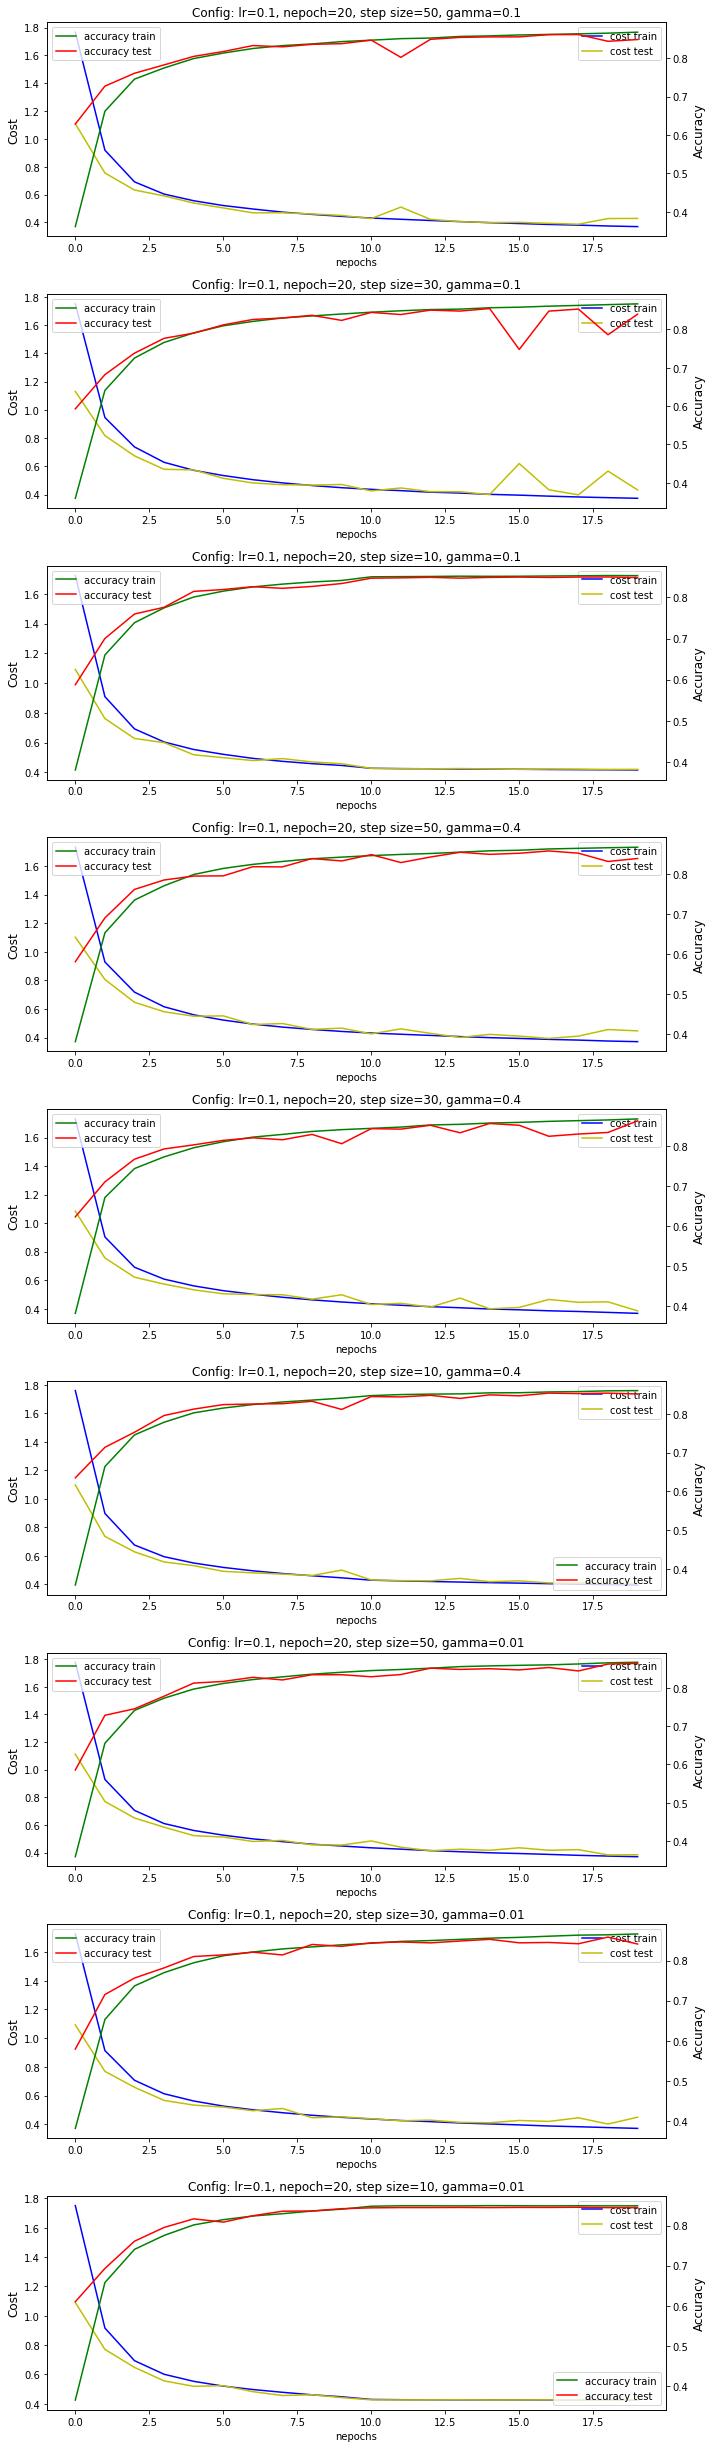

In [76]:
plt.rcParams["figure.figsize"] = (10,45)

for i in range(len(lr)):
    plt.subplot(12,1,1+i)
    plt.tight_layout()
    plt.plot(torch.arange(nepochs[i]), costs_train_steplr[i], label="cost train", color="b")
    plt.plot(torch.arange(nepochs[i]), costs_test_steplr[i], label="cost test", color="y")
    plt.legend()
    plt.xlabel("nepochs")
    plt.ylabel("Cost", fontsize=12)
    plt.title(f"Config: lr={lr[i]}, nepoch={nepochs[i]}, step size={step_size[i]}, gamma={gamma[i]}")
    plt2 = plt.twinx()
    plt2.plot(torch.arange(nepochs[i]), acc_train_steplr[i], label="accuracy train", color="g")
    plt2.plot(torch.arange(nepochs[i]), acc_test_steplr[i], label="accuracy test", color="r")
    plt2.legend()
    plt2.set_ylabel("Accuracy", fontsize=12)

# Example WandB

__Create an account ->__ [wandb.ai](https://wandb.ai)

## Import WandB and login

In [89]:
import torch
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from torchvision import datasets, transforms

In [77]:
import wandb

wandb.login()

wandb: Currently logged in as: awilli (use `wandb login --relogin` to force relogin)


True

In [78]:
sweep_config = {
    'method': 'grid'
    }

In [79]:
metric = {
    'name': 'loss',
    'goal': 'minimize'   
    }

sweep_config['metric'] = metric

In [80]:
parameters_dict = {
    'learning_rate': {
        'values': [0.1, 0.01, 0.001, 0.0001]
    },
    'epochs': {
        'values': [10, 20, 30]
    },
    'batch_size': {
        'values': [64, 128]
    }
}

sweep_config['parameters'] = parameters_dict

In [81]:
import pprint

pprint.pprint(sweep_config)

{'method': 'grid',
 'metric': {'goal': 'minimize', 'name': 'loss'},
 'parameters': {'batch_size': {'values': [64, 128]},
                'epochs': {'values': [10, 20, 30]},
                'learning_rate': {'values': [0.1, 0.01, 0.001, 0.0001]}}}


In [82]:
sweep_id = wandb.sweep(sweep_config, project="pw05")

Create sweep with ID: bg0g4ucn
Sweep URL: https://wandb.ai/awilli/pw05/sweeps/bg0g4ucn


In [83]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train(config=None):
    # Initialize a new wandb run
    with wandb.init(config=config):
        
        # If called by wandb.agent, as below,
        # this config will be set by Sweep Controller
        config = wandb.config

        loader = build_dataset(config.batch_size)
        network = build_network()
        optimizer = build_optimizer(network, config.learning_rate)

        for epoch in range(config.epochs):
            avg_loss = train_epoch(network, loader, optimizer)
            wandb.log({"loss": avg_loss, "epoch": epoch}) 

In [87]:
def build_dataset(batch_size):
   
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
    
    # download MNIST training dataset
    dataset = datasets.MNIST(".", train=True, download=True, transform=transform)
    sub_dataset = torch.utils.data.Subset(dataset, indices=range(0, len(dataset), 5))
    loader = torch.utils.data.DataLoader(sub_dataset, batch_size=batch_size)

    return loader

def build_network(units = [28*28,250,80,10]):
    seq = [torch.nn.Flatten()]
    for i in range(len(units)-2):
        seq.append(torch.nn.Linear(units[i],units[i+1]))
        seq.append(torch.nn.Sigmoid())
    seq.append(torch.nn.Linear(units[-2],units[-1]))
    return torch.nn.Sequential(*seq).to(device)
        

def build_optimizer(network, learning_rate):
    return optim.Adam(network.parameters(), lr=learning_rate)
   

def train_epoch(network, loader, optimizer):
    cumu_loss = 0
    for _, (data, target) in enumerate(loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()

        # ➡ Forward pass
        loss = F.nll_loss(network(data), target)
        cumu_loss += loss.item()

        # ⬅ Backward pass + weight update
        loss.backward()
        optimizer.step()

        wandb.log({"batch loss": loss.item()})

    return cumu_loss / len(loader)

In [90]:
wandb.agent(sweep_id, train, count=5)

wandb: Agent Starting Run: xdjtqlpx with config:
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001


batch loss,████▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,██▇▇▇▆▆▅▅▅▄▄▄▃▃▂▂▂▁▁
batch loss,-281.06116
epoch,19
loss,-274.35555


wandb: Agent Starting Run: 6l1c4ki0 with config:
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0001


batch loss,███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,██▇▇▆▆▆▅▅▅▄▄▄▃▃▂▂▂▁▁
batch loss,-27.30492
epoch,19
loss,-26.6307


wandb: Agent Starting Run: 82uizpiw with config:
wandb: 	batch_size: 64
wandb: 	epochs: 30
wandb: 	learning_rate: 0.1


batch loss,████▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,███▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▁▁▁
batch loss,-19488.00781
epoch,29
loss,-19188.95544


wandb: Agent Starting Run: 582qoxvb with config:
wandb: 	batch_size: 64
wandb: 	epochs: 30
wandb: 	learning_rate: 0.01


batch loss,████▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,███▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▁▁▁
batch loss,-4285.61865
epoch,29
loss,-4220.0796


wandb: Agent Starting Run: t5g7endt with config:
wandb: 	batch_size: 64
wandb: 	epochs: 30
wandb: 	learning_rate: 0.001


batch loss,████▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,███▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▁▁▁
batch loss,-430.00467
epoch,29
loss,-423.57185
